In [1]:
import os
import zarr
import timm
import random
import json
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import sys
import torch

# import torchvision.transforms.functional as F
import random

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import Unet3D
from src.utils import save_images, PadToSize
from src.metric import (
    score,
    create_cls_pos,
    create_cls_pos_sikii,
    create_df,
    SegmentationLoss,
    DiceLoss,
)
from metric import visualize_epoch_results
from src.utils import save_images
from src.metric import score, create_cls_pos, create_cls_pos_sikii, create_df
from src.inference import inference, inference2pos
from src.kaggle_notebook_metric import compute_lb

sample_submission = pd.read_csv("../../inputs/sample_submission.csv")

In [2]:
def create_gt_df(base_dir, exp_names):
    result_df = None
    particle_names = CFG.particles_name

    for exp_name in exp_names:
        for particle in particle_names:
            np_corrds = read_info_json(
                base_dir=base_dir, exp_name=exp_name, particle_name=particle
            )  # (n, 3)
            # 各行にexp_nameとparticle_name追加
            particle_df = pd.DataFrame(np_corrds, columns=["z", "y", "x"])
            particle_df["experiment"] = exp_name
            particle_df["particle_type"] = particle

            if result_df is None:
                result_df = particle_df
            else:
                result_df = pd.concat([result_df, particle_df], axis=0).reset_index(
                    drop=True
                )

    result_df = result_df.reset_index()
    result_df = result_df[["index", "experiment", "particle_type", "x", "y", "z"]]

    return result_df


gt_df = create_gt_df("../../inputs/train/overlay/ExperimentRuns/", CFG.train_exp_names)
gt_df

,index,experiment,particle_type,x,y,z
0,0,TS_4,apo-ferritin,3045.036742,919.139280,421.270403
1,1,TS_4,apo-ferritin,2969.078552,1027.114255,440.085721
2,2,TS_4,apo-ferritin,2839.792769,1069.080767,425.839468
3,3,TS_4,apo-ferritin,2875.180486,1077.907940,298.254286
4,4,TS_4,apo-ferritin,2765.950544,1019.336833,322.072039
...,...,...,...,...,...,...
14628,14628,TS_6_6,virus-like-particle,2609.876000,4569.876000,1169.759000
14629,14629,TS_6_6,virus-like-particle,2213.287000,4135.017000,1286.851000
14630,14630,TS_6_6,virus-like-particle,3303.905000,5697.825000,789.744000
14631,14631,TS_6_6,virus-like-particle,1008.748000,5949.213000,1077.303000


In [3]:
import torch
import timm
from typing import OrderedDict


def combine_models(
    models: list[torch.nn.Module],
    model_weights: list[float],
) -> torch.nn.Module:
    """
    How:
        モデルのパラメータを、渡されたそれぞれの重みに応じて重み付き平均して1つのモデルにまとめる。

    Parameters:
    ----------
    models : list[torch.nn.Module]
        重み付き平均したいモデルたち。
    model_weights : list[float]
        上記モデルたちに対応した重み。

    Returns:
    -------
    torch.nn.Module
        重み付き平均されたモデル。
    """
    # Why not: model_weightsの長さとmodelsの数が一致しない場合はエラーを出す以外に、
    #         例外を投げる方法もあるが、そのままにする。
    assert len(models) == len(model_weights), "モデルと重みの数が一致していません。"

    # Why not: PyTorchのModuleを新規に作り直す方法もあるが、最初のモデルをコピーして
    #         そこに重みを上書きする形が簡単。
    # ここでは models[0] のstate_dictをコピーして初期化し、それに各モデルを加算していく
    base_state_dict = models[0].state_dict()
    new_state_dict = OrderedDict()

    # 合計重み(正規化のため)を計算
    weight_sum = sum(model_weights)

    with torch.no_grad():
        for key in base_state_dict.keys():
            # if "encoder" in key:  # encoderは重み平均しない
            #     new_state_dict[key] = base_state_dict[key]
            #     continue

            # encoderの重みのみ平均
            if "encoder" in key:
                avg_param = base_state_dict[key] * model_weights[0]
                for i in range(1, len(models)):
                    avg_param += models[i].state_dict()[key] * model_weights[i]
                avg_param /= weight_sum
                new_state_dict[key] = avg_param
                continue
            else:
                new_state_dict[key] = base_state_dict[key]
                continue

            # まず最初のモデルのパラメータ*重み で初期化
            avg_param = base_state_dict[key] * model_weights[0]

            # 残りのモデルを加算
            for i in range(1, len(models)):
                avg_param += models[i].state_dict()[key] * model_weights[i]

            # 重み和で割って正規化
            avg_param /= weight_sum
            new_state_dict[key] = avg_param

    # 新しいモデル(同じアーキテクチャ)を作り、new_state_dictをロード
    # ここでは例としてmodels[0]と同じクラスを使う
    combined_model = type(models[0])(
        encoder=models[0].encoder,  # Unet3Dのコンストラクタ引数を流用
        num_domains=5,
    )
    combined_model.load_state_dict(new_state_dict)

    return combined_model

In [4]:
import torch
import timm

# 例としてtimmのエンコーダを作成
# (Unet3Dはユーザー定義クラスで、同一クラス・同一初期化が必要)
encoder = timm.create_model(
    model_name=CFG.model_name,
    pretrained=True,
    in_chans=3,
    num_classes=0,
    global_pool="",
    features_only=True,
)

# モデルのインスタンス化
model01 = Unet3D(encoder=encoder, num_domains=5)
model02 = Unet3D(encoder=encoder, num_domains=5)
model03 = Unet3D(encoder=encoder, num_domains=5)
model04 = Unet3D(encoder=encoder, num_domains=5)
model05 = Unet3D(encoder=encoder, num_domains=5)
model06 = Unet3D(encoder=encoder, num_domains=5)

# モデルのロード
# model01.load_state_dict(torch.load("./TS_69_2/best_model.pth"))
# model02.load_state_dict(torch.load("./TS_6_4/best_model.pth"))
# model03.load_state_dict(torch.load("./TS_6_6/best_model.pth"))
model04.load_state_dict(torch.load("./TS_73_6/best_model.pth"))
# model05.load_state_dict(torch.load("./TS_86_3/best_model.pth"))
model06.load_state_dict(torch.load("./TS_99_9/best_model.pth"))

# 各モデルに対する重み
model01_m = 0.0
model02_m = 0.0  # 01
model03_m = 0.0  # 01
model04_m = 1.0  # 01
model05_m = 0.0  # 01
model06_m = 1.0  # 01

# モデルをまとめる
# models = [model01, model02, model03, model04, model05, model06]
# model_weights = [model01_m, model02_m, model03_m, model04_m, model05_m, model06_m]

models = [model04, model06]
model_weights = [model04_m, model06_m]

combined_model = combine_models(models, model_weights).cuda()
torch.save(combined_model.state_dict(), "./combined_model.pth")

In [5]:
model = combined_model
# model = model01.cuda()

In [6]:
import timm

# encoder = timm.create_model(
#     model_name=CFG.model_name,
#     pretrained=True,
#     in_chans=3,
#     num_classes=0,
#     global_pool="",
#     features_only=True,
# )
# model = Unet3D(encoder=encoder, num_domains=5).to("cuda")
# model.load_state_dict(torch.load("./best_model.pth"))

# inferenced_array = inference(model, exp_name, train=False)
# 0.7303962244998289

In [7]:
exp_names = CFG.valid_exp_names  # ["TS_6_4", "TS_5_4", "TS_69_2"]

import gc
from tqdm import tqdm


constant = 0.25
sikii = {
    "apo-ferritin": constant,
    "beta-amylase": constant,
    "beta-galactosidase": constant,
    "ribosome": constant,
    "thyroglobulin": constant,
    "virus-like-particle": constant,
}

pred_dict = {}

# for exp_name in tqdm(CFG.train_exp_names):
for exp_name in tqdm(exp_names):  # 5つのデータで試す

    inferenced_array, n_tomogram, segmentation_map = inference(
        # model01,
        combined_model.cuda(),
        exp_name,
        train=False,
        base_dir="../../inputs/train/",
    )

    # inferenced_array, n_tomogram, segmentation_map = inference(
    #     model01.cuda(),
    #     exp_name,
    #     train=False,
    #     base_dir="../../inputs/train/",
    # )
    # del model01
    # pred_dict[exp_name] = inferenced_array

    # i, _, _ = inference(
    #     model02.cuda(),
    #     exp_name,
    #     train=False,
    #     base_dir="../../inputs/train/",
    # )
    # del model02
    # inferenced_array += i

    # i, _, _ = inference(
    #     model03.cuda(),
    #     exp_name,
    #     train=False,
    #     base_dir="../../inputs/train/",
    # )
    # del model03
    # inferenced_array += i

    # i, _, _ = inference(
    #     model04.cuda(),
    #     exp_name,
    #     train=False,
    #     base_dir="../../inputs/train/",
    # )
    # del model04
    # inferenced_array += i

    # i, _, _ = inference(
    #     model05.cuda(),
    #     exp_name,
    #     train=False,
    #     base_dir="../../inputs/train/",
    # )
    # del model05
    # inferenced_array += i

    # i, _, _ = inference(
    #     model06.cuda(),
    #     exp_name,
    #     train=False,
    #     base_dir="../../inputs/train/",
    # )
    # del model
    # inferenced_array += i

    # inferenced_array /= 3

    gc.collect()

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1, 16, 1, 640, 640])
torch.Size([1, 16, 1, 640, 640])
torch.Size([1, 16, 1, 640, 640])
torch.Size([1, 16, 1, 640, 640])
torch.Size([1, 16, 1, 640, 640])
torch.Size([1, 16, 1, 640, 640])
torch.Size([1, 16, 1, 640, 640])
torch.Size([1, 16, 1, 640, 640])
torch.Size([1, 16, 1, 640, 640])
torch.Size([1, 16, 1, 640, 640])
torch.Size([1, 16, 1, 640, 640])
torch.Size([1, 16, 1, 640, 640])
torch.Size([1, 16, 1, 640, 640])
torch.Size([1, 16, 1, 640, 640])
torch.Size([1, 16, 1, 640, 640])
torch.Size([1, 16, 1, 640, 640])
torch.Size([1, 16, 1, 640, 640])
torch.Size([1, 16, 1, 640, 640])
torch.Size([1, 16, 1, 640, 640])
torch.Size([1, 16, 1, 640, 640])
torch.Size([1, 16, 1, 640, 640])
torch.Size([1, 16, 1, 640, 640])
torch.Size([1, 16, 1, 640, 640])


100%|██████████| 1/1 [00:18<00:00, 18.63s/it]


In [8]:
# pred_df = pd.concat(all_pred, axis=0).reset_index(drop=True)
# pred_df = pred_df[pred_df["particle_type"] != "beta-amylase"]
# pred_df = pred_df.drop_duplicates(
#     subset=["experiment", "x", "y", "z"], keep="first"
# ).reset_index(drop=True)
# pred_df = pred_df.reset_index().rename(columns={"index": "id"})
# pred_df

In [9]:
gt_df = create_gt_df("../../inputs/train/overlay/ExperimentRuns/", exp_names)
gt_df

,index,experiment,particle_type,x,y,z
0,0,TS_5_4,apo-ferritin,468.514,5915.906,604.167
1,1,TS_5_4,apo-ferritin,5674.694,1114.354,565.068
2,2,TS_5_4,apo-ferritin,5744.509,1049.172,653.712
3,3,TS_5_4,apo-ferritin,5880.769,1125.348,579.560
4,4,TS_5_4,apo-ferritin,4661.667,1269.497,810.409
...,...,...,...,...,...,...
135,135,TS_5_4,virus-like-particle,2636.539,4214.980,965.410
136,136,TS_5_4,virus-like-particle,3137.396,3572.460,372.914
137,137,TS_5_4,virus-like-particle,3294.133,3027.464,674.070
138,138,TS_5_4,virus-like-particle,2997.686,4948.218,1169.375


In [10]:
# sikii値とexp_namesを入れるとスコアを出力する関数


def compute_score(sikii_list, inferenced_array, exp_name):
    apo_ferritin = sikii_list[0]
    beta_amylase = sikii_list[1]
    beta_galactosidase = sikii_list[2]
    ribosome = sikii_list[3]
    thyroglobulin = sikii_list[4]
    virus_like_particle = sikii_list[5]

    sikii_dict = {
        "apo-ferritin": apo_ferritin,
        "beta-amylase": beta_amylase,
        "beta-galactosidase": beta_galactosidase,
        "ribosome": ribosome,
        "thyroglobulin": thyroglobulin,
        "virus-like-particle": virus_like_particle,
    }

    all_pred = []

    pred_df = inference2pos(
        pred_segmask=inferenced_array, exp_name=exp_name, sikii_dict=sikii_dict
    )

    all_pred.append(pred_df)

    gc.collect()

    pred_df = pd.concat(all_pred, axis=0).reset_index(drop=True)
    pred_df = pred_df[pred_df["particle_type"] != "beta-amylase"]
    pred_df = pred_df.drop_duplicates(
        subset=["experiment", "x", "y", "z"], keep="first"
    ).reset_index(drop=True)
    pred_df = pred_df.reset_index().rename(columns={"index": "id"})

    gt_df = create_gt_df("../../inputs/train/overlay/ExperimentRuns/", [exp_name])

    result_df, lb_score = compute_lb(
        pred_df, "../../inputs/train/overlay/ExperimentRuns/", [exp_name]
    )

    return lb_score


def reduce_computation_sikii_search(
    inferenced_array: np.ndarray, exp_name: str, threshold_candidates: list[float]
) -> tuple[list[float], float]:
    """
    # How
    6つのしきい値が互いに独立してスコアに貢献しているという前提で、
    1次元ずつ最適なしきい値を探す手法を実装する.

    1. 初期の best_thresholds (全要素 0.5 など適当な値) を用意
    2. i=0 から i=5 まで順番に:
       - threshold_candidates をすべて試し、他は固定したまま i 番目だけ変化させてスコアを計算
       - 最良スコアが得られる候補値を確定し、best_thresholds[i] とする
    3. 全部決まったら最終的なスコアを計算して返す

    これにより、全組み合わせ (product) を回すよりも計算量が大幅に減少する.
    """
    # Why not: 6値独立であるという前提が満たされていない場合、近似解になる可能性あり
    best_thresholds = [0.5] * 6  # 適当な初期値でOK

    for i in tqdm(range(6)):
        best_local_score = -float("inf")
        best_local_value = None

        for candidate in threshold_candidates:
            current_thresholds = best_thresholds[:]  # 現在のベストを複製
            current_thresholds[i] = candidate
            try:
                score = compute_score(current_thresholds, inferenced_array, exp_name)
            except:
                score = -float("inf")
            if score > best_local_score:
                best_local_score = score
                best_local_value = candidate

        # i番目のしきい値を最適値に更新
        best_thresholds[i] = best_local_value

    final_score = compute_score(best_thresholds, inferenced_array, exp_name)
    return best_thresholds, final_score

In [11]:
# compute_score([0.25, 0.25, 0.25, 0.25, 0.25, 0.25], exp_names)

In [12]:
# 平均値
from sklearn.metrics import *
from scipy.optimize import minimize
import gc
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution

exp_name = CFG.valid_exp_names[0]

# inferenced_array, n_tomogram, segmentation_map = inference(
#     model,
#     exp_name,
#     train=False,
#     base_dir="../../inputs/train/",
# )

In [13]:
# del model
# gc.collect()
# torch.cuda.empty_cache()

In [14]:
def softmx(x):
    # x: (cls, depth, height, width)
    x = np.exp(x)
    x = x / x.sum(axis=0)
    return x


# inferenced_array = softmx(inferenced_array)

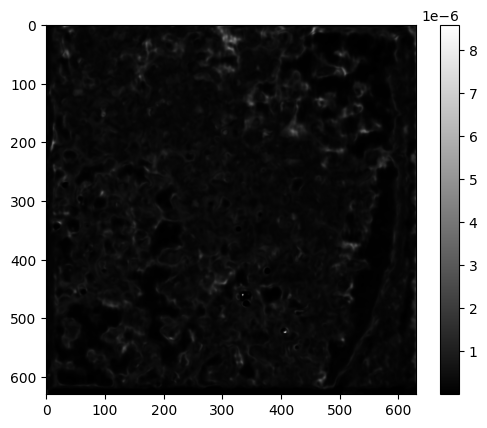

In [15]:
depth = 130
cls = 5
# inferenced_array[cls, depth]

import matplotlib.pyplot as plt

plt.imshow(inferenced_array[cls, depth], cmap="gray")
plt.colorbar()

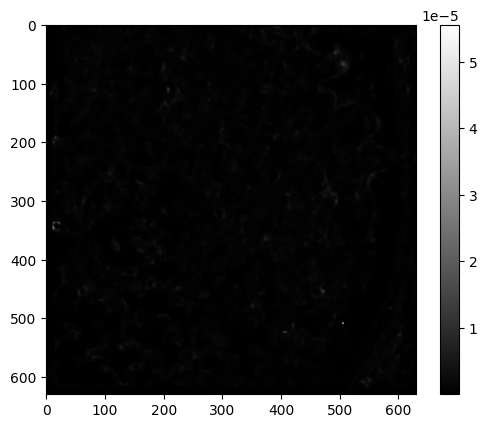

In [16]:
depth = 121
cls = 5
# inferenced_array[cls, depth]

import matplotlib.pyplot as plt

plt.imshow(inferenced_array[cls, depth], cmap="gray")
plt.colorbar()

In [17]:
# KappaOPtimizer = minimize(
#     compute_score,
#     x0=[0.90, 0.90, 0.90, 0.90, 0.90, 0.90],
#     args=(inferenced_array, exp_name),
#     bounds=[(0.0, 0.95) for _ in range(6)],
#     method="nelder-mead",
#     options={"maxiter": 50},
# )

inferenced_array = softmx(inferenced_array)

best_thresholds, final_score = reduce_computation_sikii_search(
    # inferenced_array, exp_name, np.linspace(0.000001, 0.5, 20)
    inferenced_array,
    exp_name,
    np.linspace(0.01, 0.75, 12),
)

100%|██████████| 6/6 [02:37<00:00, 26.19s/it]


In [18]:
best_thresholds

[0.14454545454545456,
 0.01,
 0.14454545454545456,
 0.14454545454545456,
 0.14454545454545456,
 0.14454545454545456]

In [19]:
inferenced_array

array([[[[0.311791  , 0.311791  , 0.311791  , ..., 0.311791  ,
          0.311791  , 0.311791  ],
         [0.311791  , 0.311791  , 0.311791  , ..., 0.31178983,
          0.31178954, 0.3117893 ],
         [0.311791  , 0.311791  , 0.311791  , ..., 0.31179019,
          0.31178975, 0.31178948],
         ...,
         [0.311791  , 0.31179028, 0.31179073, ..., 0.31178867,
          0.31178944, 0.31179016],
         [0.311791  , 0.31179011, 0.31179059, ..., 0.31178906,
          0.31178968, 0.31179025],
         [0.311791  , 0.31178996, 0.31179052, ..., 0.31178962,
          0.31178993, 0.31179037]],

        [[0.311791  , 0.311791  , 0.311791  , ..., 0.311791  ,
          0.31179097, 0.31179097],
         [0.311791  , 0.311791  , 0.311791  , ..., 0.31178915,
          0.31178915, 0.31178915],
         [0.311791  , 0.311791  , 0.311791  , ..., 0.31178975,
          0.3117893 , 0.31178903],
         ...,
         [0.31179097, 0.31178954, 0.31179055, ..., 0.31178757,
          0.31178879, 0.3

In [20]:
compute_score(best_thresholds, inferenced_array, exp_name)

0.4202727996863486

In [21]:
exp_name

'TS_5_4'

In [22]:
CFG.valid_exp_names

['TS_5_4']

In [23]:
best_thresholds

[0.14454545454545456,
 0.01,
 0.14454545454545456,
 0.14454545454545456,
 0.14454545454545456,
 0.14454545454545456]

In [24]:
apo_ferritin = best_thresholds[0]
beta_amylase = best_thresholds[1]
beta_galactosidase = best_thresholds[2]
ribosome = best_thresholds[3]
thyroglobulin = best_thresholds[4]
virus_like_particle = best_thresholds[5]

sikii_dict = {
    "apo-ferritin": apo_ferritin,
    "beta-amylase": beta_amylase,
    "beta-galactosidase": beta_galactosidase,
    "ribosome": ribosome,
    "thyroglobulin": thyroglobulin,
    "virus-like-particle": virus_like_particle,
}

sikii_dict

{'apo-ferritin': 0.14454545454545456,
 'beta-amylase': 0.01,
 'beta-galactosidase': 0.14454545454545456,
 'ribosome': 0.14454545454545456,
 'thyroglobulin': 0.14454545454545456,
 'virus-like-particle': 0.14454545454545456}

In [25]:
data_copy0 = input_tensor.clone()
data_copy0 = torch.flip(data_copy0, dims=[2])  # torch.Size([1, 1, 96, 96, 96])
data_copy1 = input_tensor.clone()
data_copy1 = torch.flip(data_copy1, dims=[3])
data_copy2 = input_tensor.clone()
data_copy2 = torch.flip(data_copy2, dims=[4])
data_copy3 = input_tensor.clone()
data_copy3 = data_copy3.rot90(1, dims=[3, 4])
data_copy4 = input_tensor.clone().transpose(1, 2)

NameError: name 'input_tensor' is not defined